In [132]:
!nvidia-smi

Mon Oct  2 17:00:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |   1845MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!cd /content/drive/MyDrive/FaceRecognition

/content/drive/MyDrive/FaceRecognition


In [13]:
import torch
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
import torchvision
from torchvision import transforms, utils, datasets, models
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
	      transforms.ToTensor(),
	      transforms.Resize((224,224)),
	      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
	      transforms.RandomRotation(5, expand=False, center=None),
	      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
       ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
	      transforms.Resize((224,224)),
	      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
	      transforms.RandomRotation(5, expand=False, center=None),
	      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
}

data_dir = '/content/drive/MyDrive/FaceRecognition/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes
class_names

['Anupama', 'Kaifeng', 'Revanth']

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


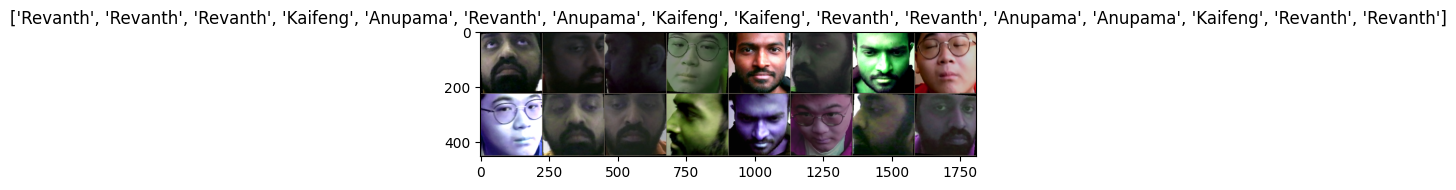

In [8]:
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
out = utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [33]:
from inception_resnet_v1 import InceptionResnetV1
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Running on device: {}'.format(device))

model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=len(class_names))

list(model_ft.children())[-6:]

layer_list = list(model_ft.children())[-5:]  # all final layers

model_ft = nn.Sequential(*list(model_ft.children())[:-5])

for param in model_ft.parameters():
    param.requires_grad = False


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x


class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()

    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x


model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)

model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)

model_ft.logits = nn.Linear(layer_list[2].out_features, len(class_names))
model_ft.softmax = nn.Softmax(dim=1)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft

Running on device: cuda


  0%|          | 0.00/107M [00:00<?, ?B/s]

Sequential(
  (0): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (1): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (2): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (5): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3,

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    FT_losses = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                FT_losses.append(loss.item())

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, FT_losses

Epoch 0/199
----------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


train Loss: 1.0977 Acc: 0.4121
val Loss: 1.0975 Acc: 0.3962
Epoch 1/199
----------
train Loss: 1.0956 Acc: 0.5678
val Loss: 1.0956 Acc: 0.4528
Epoch 2/199
----------
train Loss: 1.0954 Acc: 0.5980
val Loss: 1.0962 Acc: 0.4528
Epoch 3/199
----------
train Loss: 1.0955 Acc: 0.6030
val Loss: 1.0958 Acc: 0.5283
Epoch 4/199
----------
train Loss: 1.0950 Acc: 0.6181
val Loss: 1.0956 Acc: 0.4151
Epoch 5/199
----------
train Loss: 1.0953 Acc: 0.5980
val Loss: 1.0964 Acc: 0.3962
Epoch 6/199
----------
train Loss: 1.0949 Acc: 0.6432
val Loss: 1.0959 Acc: 0.4340
Epoch 7/199
----------
train Loss: 1.0952 Acc: 0.6080
val Loss: 1.0954 Acc: 0.4906
Epoch 8/199
----------
train Loss: 1.0954 Acc: 0.5930
val Loss: 1.0961 Acc: 0.4340
Epoch 9/199
----------
train Loss: 1.0952 Acc: 0.5779
val Loss: 1.0954 Acc: 0.3962
Epoch 10/199
----------
train Loss: 1.0951 Acc: 0.6030
val Loss: 1.0954 Acc: 0.4528
Epoch 11/199
----------
train Loss: 1.0954 Acc: 0.5980
val Loss: 1.0952 Acc: 0.4340
Epoch 12/199
----------
t

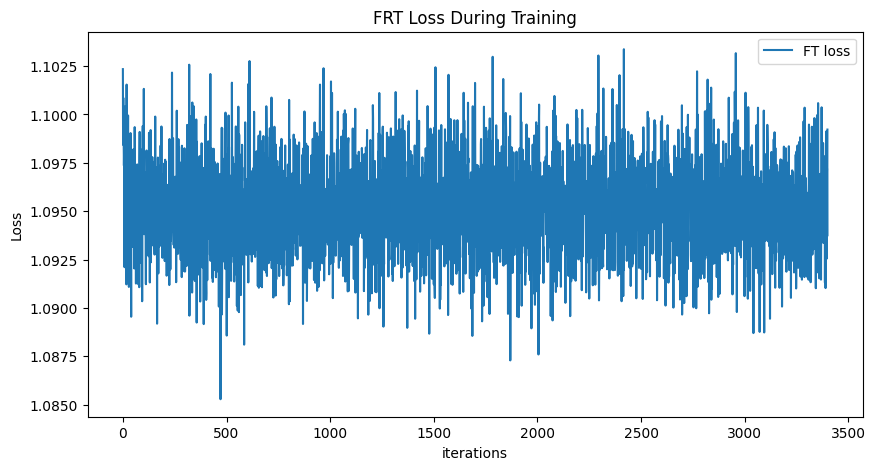

In [35]:
model_ft, FT_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=200)

plt.figure(figsize=(10,5))
plt.title("FRT Loss During Training")
plt.plot(FT_losses, label="FT loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

torch.save(model_ft, "/faceRecogniser.pt")

In [37]:
torch.save(model_ft, "faceRecogniser.pt")

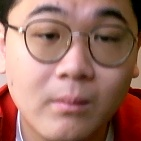

In [129]:
from google.colab.patches import cv2_imshow
img_path = "/content/drive/MyDrive/FaceRecognition/val/Kaifeng/0.jpg"
img = cv2.imread(img_path)
cv2_imshow(img)

In [130]:
img_tensor = torch.from_numpy(img)
img_tensor = img_tensor.reshape(1, 3, img_tensor.shape[0], img_tensor.shape[1]).to(device).type(torch.float)
img_tensor.shape

torch.Size([1, 3, 141, 141])

In [131]:
modelX = torch.load('faceRecogniser.pt')
modelX.eval()
with torch.inference_mode():
  logits = modelX(img_tensor)
  pred_probs = torch.softmax(logits, dim=1)
  labels = torch.argmax(pred_probs)
print(logits, pred_probs, labels)

tensor([[0.3267, 0.3472, 0.3261]], device='cuda:0') tensor([[0.3311, 0.3380, 0.3309]], device='cuda:0') tensor(1, device='cuda:0')


In [127]:
modelX = torch.load('faceRecogniser.pt')
modelX.eval()
with torch.inference_mode():
  logits = modelX(img_tensor)
  pred_probs = torch.softmax(logits, dim=1)
  labels = torch.argmax(pred_probs)
print(logits, pred_probs, labels)

tensor([[0.3283, 0.3443, 0.3274]], device='cuda:0') tensor([[0.3316, 0.3370, 0.3314]], device='cuda:0') tensor(1, device='cuda:0')


In [123]:
names = image_datasets['train'].classes
names

['Anupama', 'Kaifeng', 'Revanth']

In [128]:
print(f"Model has predicted the image as: {names[labels.item()]}")

Model has predicted the image as: Kaifeng
